# Demand Forecasting

In this notebook, we will build a demand forecasting model that will take in historical sales data and predict demand for the following month. This will help suppliers manage their inventory and adjust their restock schedules to maximise their use of limited warehouse space.

Due to the large number of products and limited historical sales data, it is not feasible to build a time series model for each product. Since taking into account time-based trends is a critical aspect of demand forecasting, we will instead focus on capturing temporal trends through feature engineering, such as rolling windows of historical sales data.


In [2]:
# Installing packages 

from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import itertools
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import RFECV
import xgboost as xgb
from xgboost_distribution import XGBDistribution

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
client = bigquery.Client(project="ambient-sylph-426620-g6") # Odele

### 1. Querying data

We begin by querying data from the Google Analytics Sample Dataset, focusing on all purchases made in the period July 2016 - August 2017.

In [3]:
query = '''
    WITH purchases AS(
        SELECT distinct
            fullVisitorId AS user_id
            ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS datetime
            ,product.productSKU AS product_id
            ,product.v2ProductName AS product_name
            ,product.v2ProductCategory AS product_category
            ,product.productPrice/1000000 AS product_price
            ,product.productQuantity AS product_qty
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        LEFT JOIN UNNEST(hits.product) AS product ON TRUE
        WHERE true
            and hits.eCommerceAction.action_type  = '6'
            and product.productQuantity > 0
            and PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) < date '2017-08-01'
    )
    SELECT 
        date_trunc(datetime, day) AS ymd
        ,product_id
        ,product_name
        ,product_category AS product_category_temp
        ,product_price
        ,SUM(product_qty) AS daily_qty
        ,COUNT(distinct user_id) AS daily_user_cnt
    FROM purchases
    GROUP BY 2,1,3,4,5
    ORDER BY 1,2,3
    
'''

rows = client.query(query)
daily_sales = rows.to_dataframe()
raw_ga_data = rows.to_dataframe()

In [20]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31109 entries, 0 to 31108
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ymd                    31109 non-null  datetime64[us]
 1   product_id             31109 non-null  object        
 2   product_name           31109 non-null  object        
 3   product_category_temp  31109 non-null  object        
 4   product_price          31109 non-null  float64       
 5   daily_qty              31109 non-null  Int64         
 6   daily_user_cnt         31109 non-null  Int64         
dtypes: Int64(2), datetime64[us](1), float64(1), object(3)
memory usage: 1.7+ MB


1 product ID can have more than 1 price

In [23]:
daily_sales.groupby('product_id')['product_price'].nunique().value_counts(normalize = True).sort_index()

product_price
1    0.146168
2    0.415330
3    0.148841
4    0.157754
5    0.061497
6    0.046346
7    0.012478
8    0.011586
Name: proportion, dtype: float64

1 product ID can have more than 1 category label

In [24]:
daily_sales.groupby('product_id')['product_category_temp'].nunique().value_counts().sort_index()

product_category_temp
1    382
2    603
3    134
4      3
Name: count, dtype: int64

The data needs to be cleaned to address NA values and to re-categorise some products. For example, we want products to be categorised by item type, not brand - those under 'Google' should be recategorised to the appropriate item type label.

We will also aggregate the data by product and day to get the daily sales for each product. We will be taking each [product name, product price] pair to be a unique product so that sellers who offer different prices for 1 product can gauge how changing the price will affect demand for the next month.  

In [4]:
# Change date to datetime object
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])

# Replace nonsencial values with NA 
daily_sales.replace('(not set)', np.nan, inplace = True)
daily_sales['product_category_temp'].replace('${productitem.product.origCatName}', np.nan, inplace = True)

# Rename categories to ensure that they are MECE (mutually exclusive, comprehensively exhaustive)
daily_sales['product_category_temp'].replace(['Tumblers', 'Bottles', 'Google'], 'Drinkware', inplace = True)
daily_sales['product_category_temp'].replace(['More Bags', 'Backpacks'], 'Bags', inplace = True)
daily_sales['product_category_temp'].replace('Android', 'Apparel', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"Waze.*(Men's|Women's|Socks)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales['product_category_temp'].replace('Waze', 'Office', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales.loc[daily_sales["product_name"].str.contains(r"(oz|Bottle|Cup|Mug)", case = True, na = False), "product_category_temp"] = "Drinkware"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Journal|Notebook", case = True, na = False), "product_category_temp"] = "Notebooks & Journals"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Bag|Backpack|Tote|Rucksack", case = True, na = False), "product_category_temp"] = "Bags"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Gift Card", case = True, na = False), "v"] = "Gift Cards"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Electronics|Device|Headphones|Earbuds|Earphones|Power Bank|Speaker", case = True, na = False), "product_category_temp"] = "Electronics"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Cap|Hat", case = True, na = False), "product_category_temp"] = "Headgear"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Pen", case = True, na = False), "product_category_temp"] = "Office"

# Convert product ID to string
daily_sales["product_id"] = daily_sales['product_id'].astype("string")

# Address discrepancies in category labels by replacing with modal label
product_category_mode = daily_sales.groupby(["product_id", "product_price"])["product_category_temp"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name="product_category")
daily_sales = daily_sales.merge(product_category_mode, on = ["product_id", "product_price"], how = "left")

# Aggregate by product to find daily sales for each product
daily_sales = daily_sales.groupby(["ymd", "product_id", "product_price", "product_category"])[["daily_qty", "daily_user_cnt"]].sum().reset_index()

# Drop items with no category
daily_sales.dropna(subset = ['product_category'], inplace = True)


### 2. Generating synthetic data for Apr - Jul 2016

Since we will be taking a 3-month rolling window of historical sales data (quantity and user count) for each entry, we will need to generate synthetic data for the period of April to July 2016, to be used in August - October 2016 data. 

For each [product id, product price] pair, we will approximate the daily sales and user count in month X 2016 using a Poisson distribution centered around the average of the month X 2017. This will then be aggregated on a monthly basis to provide the monthly sales and user count for the period of April to July 2016 for each [product id, product price] pair.

In [5]:
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])

# Obtain the daily sales quantity and user count for each [product id, product price] pair in the stated month.
# If there is no entry for that [product id, product price] that day, assume it is 0.
def get_month_products(dates, month, product_prices, sales):
    date_product_price_df = pd.DataFrame(
        list(itertools.product(dates, product_prices.to_records(index=False))),
        columns=['ymd', 'product_price_pair']
    )
    date_product_price_df['product_id'] = date_product_price_df['product_price_pair'].apply(lambda x: x[0])
    date_product_price_df['product_price'] = date_product_price_df['product_price_pair'].apply(lambda x: x[1])
    date_product_price_df.drop({'product_price_pair'}, axis = 1, inplace = True)
    month_sales = pd.merge(date_product_price_df, daily_sales, how='left', on=['ymd', 'product_id', 'product_price']).fillna(0)

    return pd.concat([sales, month_sales], axis=0)

apr_dates = pd.date_range(start='2017-04-01',  end='2017-04-30', freq ='D')
apr_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 4, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
may_dates = pd.date_range(start='2017-05-01',  end='2017-05-31', freq ='D')
may_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 5, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
jun_dates = pd.date_range(start='2017-06-01',  end='2017-06-30', freq ='D')
jun_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 6, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
jul_dates = pd.date_range(start='2017-07-01',  end='2017-07-31', freq ='D')
jul_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 7, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()

# Create a dataframe with daily sales for all [product id, product price] pairs in April - July 2017
apr_jul_sales = pd.DataFrame()
apr_jul_sales = get_month_products(apr_dates, 4, apr_product_prices, apr_jul_sales)
apr_jul_sales = get_month_products(may_dates, 5, may_product_prices, apr_jul_sales)
apr_jul_sales = get_month_products(jun_dates, 6, jun_product_prices, apr_jul_sales)
apr_jul_sales = get_month_products(jul_dates, 7, jul_product_prices, apr_jul_sales)

Most daily sales are 0, meaning that a sale is a 'rare' event -  a Poisson distribution would be appropriate to model the data.

In [27]:
apr_jul_sales['daily_qty'].value_counts(normalize = True).reset_index()

,daily_qty,proportion
0,0,0.908761
1,1,0.055377
2,2,0.010741
3,3,0.00407
4,5,0.00315
...,...,...
139,890,0.000008
140,165,0.000008
141,112,0.000008
142,825,0.000008


In [ ]:
np.random.seed(123)
synthetic_data = pd.DataFrame()

months = [4, 5, 6, 7]

for month in months:
    products = apr_jul_sales[apr_jul_sales['ymd'].dt.month == month]['product_id'].unique()
    for product in products:
        prices = apr_jul_sales[(apr_jul_sales['ymd'].dt.month == month) & (apr_jul_sales['product_id'] == product)]['product_price'].unique()
        for price in prices:

            # Filter original queried data for the [product id, product price] pair in month X in 2017
            m = apr_jul_sales.loc[(apr_jul_sales['ymd'].dt.month == month) & (apr_jul_sales['product_id'] == product) & (apr_jul_sales['product_price'] == price)]
            n_train = m.shape[0]
            # print(f'price {price} for product {product} for month {month} with {m['daily_qty'].sum()} in month and {m['daily_user_cnt'].sum()} users')

            # Find the mean quantity per user for each day of the month
            m['daily_avg_qty'] = m.apply(lambda row: row['daily_qty'] / row['daily_user_cnt'] if row['daily_user_cnt'] > 0 else 0, axis=1)
            # Find the average daily sales quantity
            lambda_qty = m['daily_qty'].mean()
            # Find the average daily user count
            lambda_user_cnt = m['daily_user_cnt'].mean()
            # Find the average mean quantity per user
            lambda_avg_qty = m['daily_avg_qty'].mean()
            # Randomly generate average mean quantity per user for month X 2016
            lambda_avg_qty_i = np.random.poisson(lambda_avg_qty)
            # Randomly generate daily sales quantity and daily user count for all days in month X 2016
            sample_qty = np.random.poisson(lambda_qty, n_train)
            sample_user_cnt = np.random.poisson(lambda_user_cnt, n_train)
            # print(f'qty: {sample_qty.sum()}, user: {sample_user_cnt.sum()}, avg_qty : {lambda_avg_qty_i}')

            # If monthly user count is 0 but monthly quantity is not 0, attempt to replace monthly user count by using the formula user count = qty / average qty per user
            # If monthly user count is still 0 after using formula, set both monthly user count and monthly quantity to 0
            if (sample_user_cnt.sum() == 0 and sample_qty.sum() != 0):
                # print(f'Dividing {sample_qty.sum()} by {lambda_avg_qty_i}')
                sample_qty_spec = sample_qty.sum()
                sample_user_cnt_spec = (sample_qty.sum()//lambda_avg_qty_i).astype(int)
                if sample_user_cnt_spec == 0:
                    sample_qty_spec = 0
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price],
                                        'present_user_cnt': sample_user_cnt_spec, 'present_total_qty': sample_qty_spec})
                # print(f'qty: {sample_qty_spec}, user: {sample_user_cnt_spec}')

            # If monthly user count is more than monthly quantity or monthly quantity is 0 when monthly user count is not 0, attempt to replace monthly quantity by using the formula quantity = user count * average qty per user
            # If monthly quantity is 0 after using formula, set both monthly user count and monthly quantity to 0
            elif (sample_user_cnt.sum() > sample_qty.sum()) or (sample_user_cnt.sum() != 0 and sample_qty.sum() == 0):
                sample_user_cnt_spec = sample_user_cnt.sum()
                #print(f'multiplying {sample_user_cnt.sum()} by {lambda_avg_qty_i}')
                sample_qty_spec = (sample_user_cnt.sum()*(lambda_avg_qty_i)).astype(int)
                if sample_qty_spec == 0:
                    sample_user_cnt_spec = 0
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price], 
                                        'present_user_cnt': sample_user_cnt_spec, 'present_total_qty': sample_qty_spec})
                # print(f'qty: {sample_qty_spec}, user: {sample_user_cnt_spec}')

            # If monthly user count or monthly quantity is negative, set both to 0
            elif sample_user_cnt.sum() < 0  or sample_qty.sum() < 0:
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price], 
                                        'present_user_cnt': 0, 'present_total_qty': 0})
            else:
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price], 
                                        'present_user_cnt': sample_user_cnt.sum(), 'present_total_qty': sample_qty.sum()})
 
            synthetic_data = pd.concat([synthetic_data, month_data], ignore_index = True)


In [6]:
synthetic_data.to_csv('../data/raw_synthetic_apr_jul.csv', index=False)

Now that we have generated our synthetic data for user count and quantity in April - July 2016, let us compare the distribution of the original (April - July 2017) data to ours.

In [7]:
# Aggregate April - July 2017 sales data to a monthly basis
apr_jul_sales_monthly = apr_jul_sales.copy()
apr_jul_sales_monthly['year_month'] = apr_jul_sales_monthly['ymd'].dt.strftime('%Y-%m')
apr_jul_sales_monthly = apr_jul_sales_monthly.groupby(['year_month', 'product_category'])[['daily_qty', 'daily_user_cnt']].sum().reset_index()
apr_jul_sales_monthly = apr_jul_sales_monthly.loc[apr_jul_sales_monthly['product_category'] != 0]
apr_jul_sales_monthly.rename({'daily_qty': 'present_total_qty', 'daily_user_cnt': 'present_user_cnt'}, axis = 1, inplace = True)

# Combine synthetic and original data into 1 dataframe
synthetic_data_check = synthetic_data.copy()
synthetic_data_check = pd.merge(synthetic_data_check, daily_sales[['product_id', 'product_price', 'product_category']].drop_duplicates(), on = ['product_id', 'product_price'], how = 'left')
synthetic_data_check = synthetic_data_check.groupby(['year_month', 'product_category'])[['present_user_cnt', 'present_total_qty']].sum().reset_index()
synthetic_data_check['year_month'] = pd.to_datetime(synthetic_data_check['year_month']).dt.strftime('%Y-%m')
synthetic_data_check_full = pd.concat([apr_jul_sales_monthly, synthetic_data_check], axis = 0)
synthetic_data_check_full['batch'] = synthetic_data_check_full['year_month'].apply(lambda x: 'Original' if x[:4] == '2017' else 'Synthetic')

For monthly sales quantity, the overall distribution is roughly similar for accessories, bags, electronics, headgear and notebooks & journals. For categories such as drinkware, fun, gift cards, housewares, lifestyle and office, the variance tends to differ, though the peak is within a similar range. Apparel has the largest mistmatch, likely due to the large range of values in the original data.

Text(0.5, 0.98, 'Violin Plots to Compare Distribution of Synthetic and Original Demand')

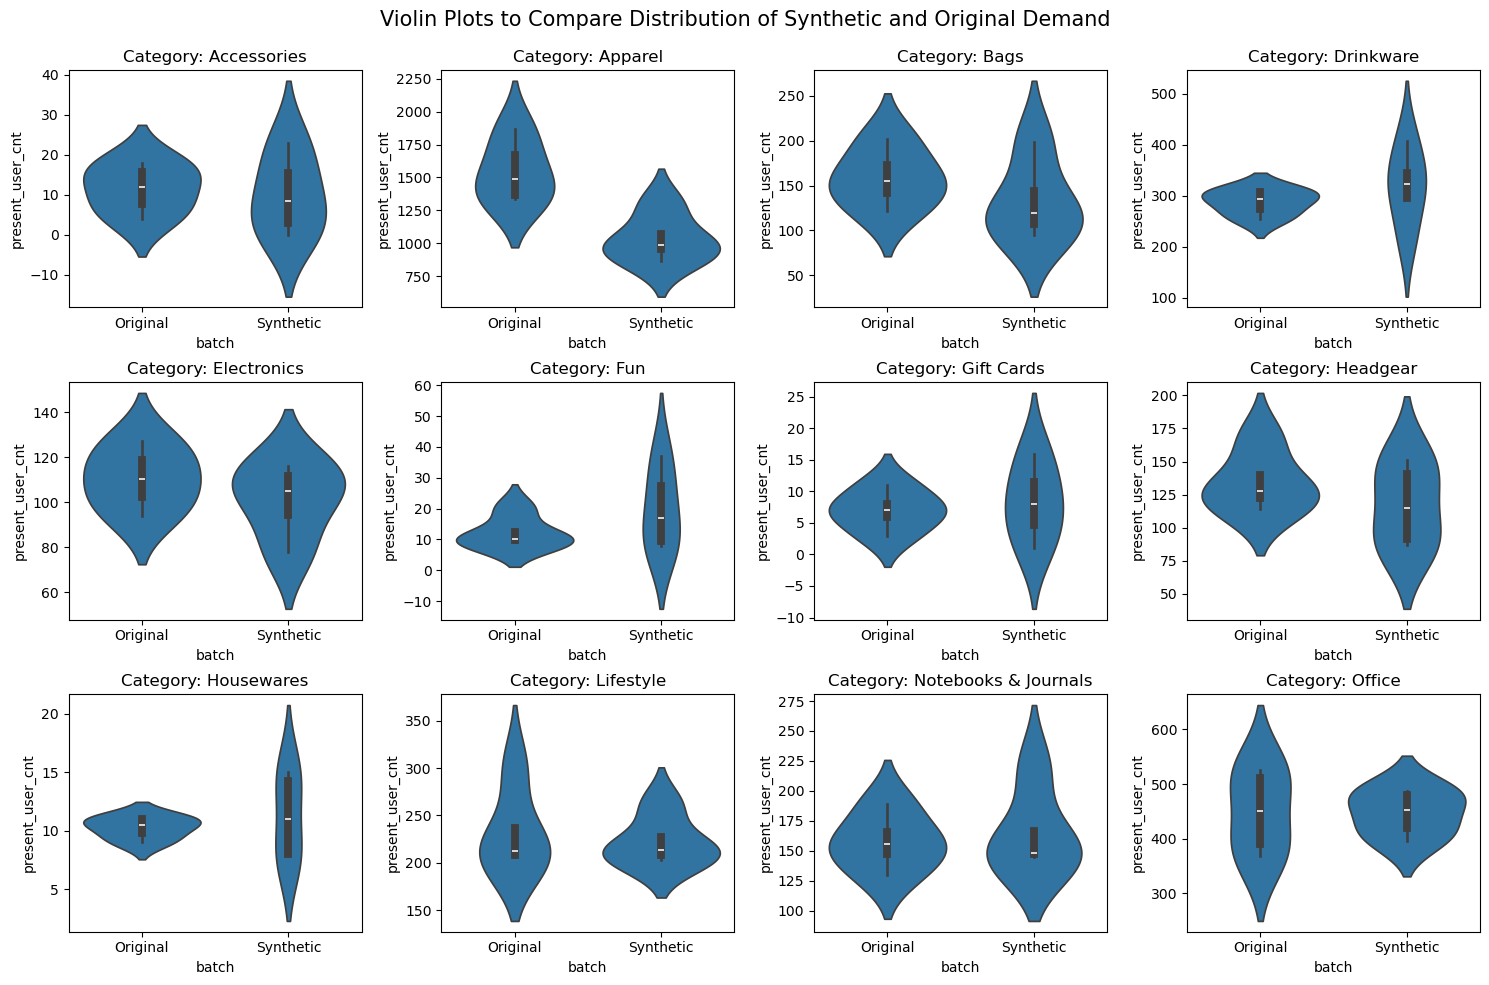

In [63]:
fig1, axes1 = plt.subplots(3, 4, figsize=(15, 10))
categories = synthetic_data_check_full['product_category'].unique()

i=0
j=0
for category in categories:
    sns.violinplot(data = synthetic_data_check_full.loc[synthetic_data_check_full['product_category'] == category], x = 'batch', y = 'present_user_cnt', ax = axes1[i, j])
    axes1[i,j].set_title(f'Category: {category}')
    if j != 3:
        j += 1
    else:
        i += 1
        j = 0

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Violin Plots to Compare Distribution of Synthetic and Original Demand', fontsize = 15)

For monthly user count, the distribution for accessories, bags, electronics, headgear and notebooks & journals is similar. For drinkware, fun, gift cards, housewares, lifestyle and office, the variance between the original and synthetic data is different but the mean is roughly the same. Similar to quantity, apparel has the largest mismatch.

Text(0.5, 0.98, 'Violin Plots to Compare Distribution of Synthetic and Original User Count')

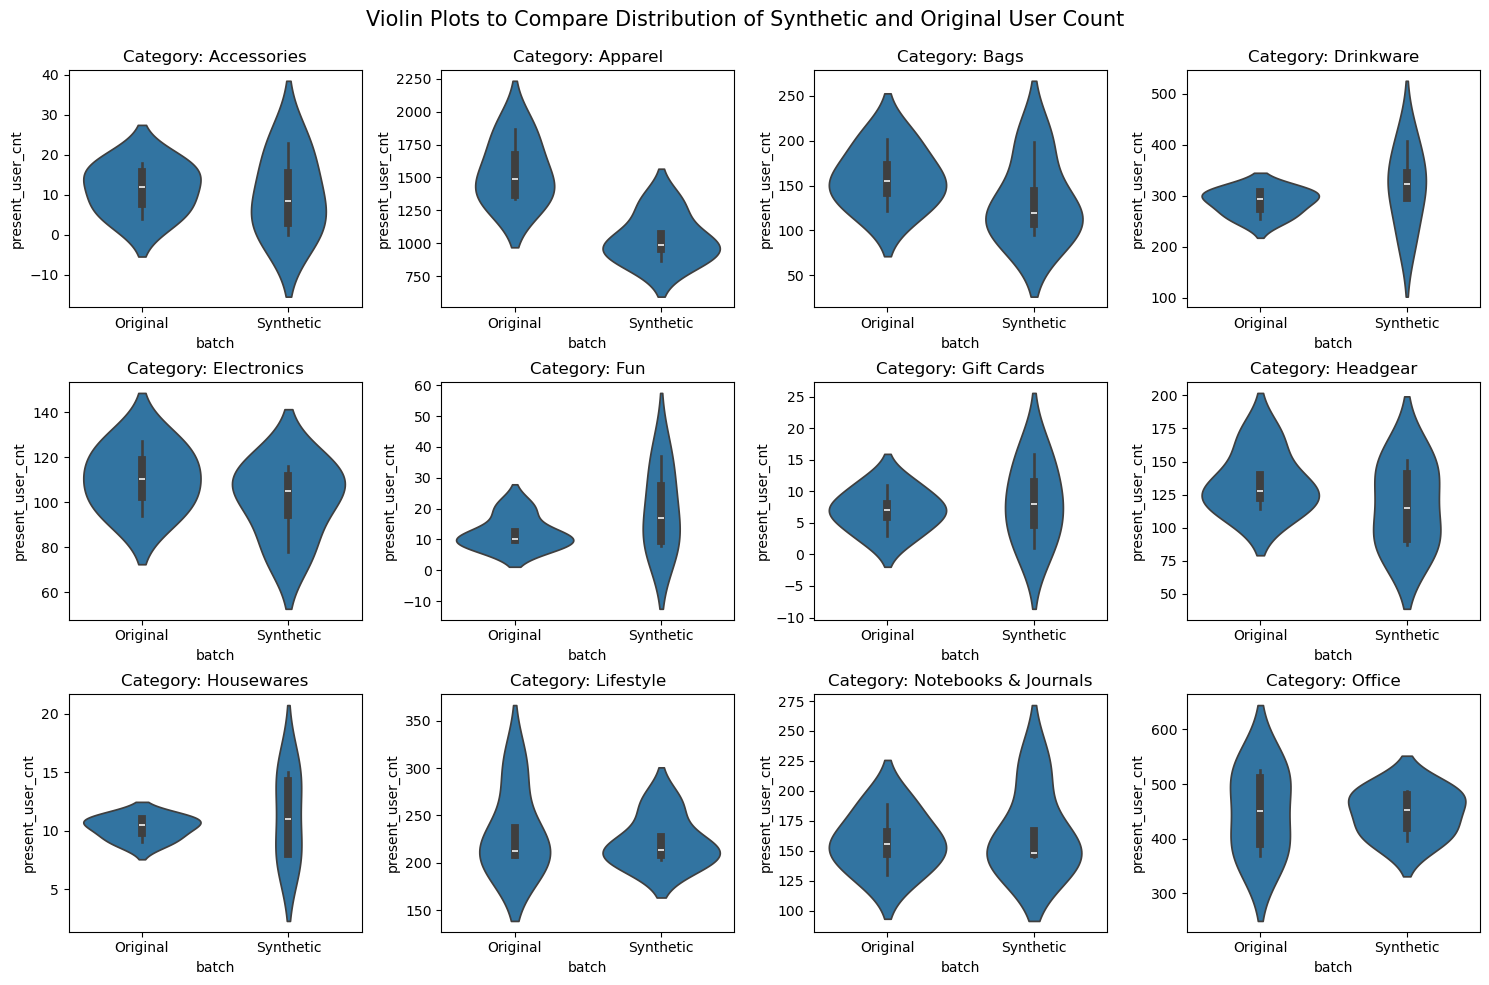

In [64]:
fig2, axes2 = plt.subplots(3, 4, figsize=(15, 10))
categories = synthetic_data_check_full['product_category'].unique()

i=0
j=0
for category in categories:
    sns.violinplot(data = synthetic_data_check_full.loc[synthetic_data_check_full['product_category'] == category], x = 'batch', y = 'present_user_cnt', ax = axes2[i, j])
    axes2[i,j].set_title(f'Category: {category}')
    if j != 3:
        j += 1
    else:
        i += 1
        j = 0

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Violin Plots to Compare Distribution of Synthetic and Original User Count', fontsize = 15)

Now that we have studied the quality of our synthetic data, we can move on to cleaning it to prepare it for merging with our original data.

In [10]:
# Obtain product category labels by merging with original data
synthetic_data = pd.merge(synthetic_data, daily_sales[['product_id', 'product_price', 'product_category']].drop_duplicates(), on = ['product_id', 'product_price'], how = 'left')
# Reorder columns and transform date into datetime object
column_order = ['year_month', 'product_id', 'product_category', 'product_price', 'present_user_cnt', 'present_total_qty']
synthetic_data = synthetic_data[column_order]
synthetic_data['year_month'] = pd.to_datetime(synthetic_data['year_month']).dt.to_period('M').dt.to_timestamp()
# synthetic_data.to_csv('../data/cleaned_synthetic_apr_jul.csv', index = False)

### 3. Data cleaning

In [6]:
# synthetic_data = pd.read_csv('../data/cleaned_synthetic_apr_jul.csv')

In [7]:
# Aggregate data to a monthly level
daily_sales['year_month'] = daily_sales['ymd'].dt.to_period('M').dt.to_timestamp()
monthly_sales = daily_sales.groupby(['year_month','product_id', 'product_category', 'product_price'])[['daily_qty', 'daily_user_cnt']].sum().reset_index()
monthly_sales.rename({'daily_qty': 'present_total_qty', 'daily_user_cnt': 'present_user_cnt'}, axis=1, inplace=True)
all_monthly_sales = pd.concat([monthly_sales, synthetic_data], ignore_index = True)
all_monthly_sales['year_month'] = pd.to_datetime(all_monthly_sales['year_month']).dt.to_period('M').dt.to_timestamp()

In [9]:
# Make sure that each product-price pair appears in all months
all_months = pd.date_range(start='2016-04-01', end='2017-07-01', freq='MS')
unique_products = all_monthly_sales['product_id'].drop_duplicates()
months_products_combos = pd.MultiIndex.from_product([unique_products, all_months], names=['product_id', 'year_month'])
months_products_combos = pd.DataFrame(index = months_products_combos).reset_index()
months_products_combos['year_month'] = pd.to_datetime(months_products_combos['year_month']).dt.to_period('M').dt.to_timestamp()
months_products_price = pd.merge(months_products_combos, all_monthly_sales[['product_id', 'product_price', 'product_category']].drop_duplicates(), on  = 'product_id', how = 'left')
all_months_products = pd.merge(months_products_price, all_monthly_sales, on = ['product_id', 'product_price', 'year_month','product_category'], how = 'left')

all_months_products[['present_total_qty', 'present_user_cnt']] = all_months_products[['present_total_qty', 'present_user_cnt']].fillna(0)
all_months_products['year_month'] = pd.to_datetime(all_months_products['year_month'])
all_months_products['month'] = all_months_products['year_month'].dt.strftime('%b')

### 4. EDA

In [31]:
# Define the color palette
colors = [
    '#1f77b4',  # Muted Blue
    '#ff7f0e',  # Muted Orange
    '#2ca02c',  # Muted Green
    '#d62728',  # Muted Red
    '#9467bd',  # Muted Purple
    '#8c564b',  # Brownish
    '#e377c2',  # Soft Pink
    '#7f7f7f',  # Medium Grey
    '#bcbd22',  # Olive Green
    '#17becf',  # Teal
    '#c5b0d5',  # Soft Lavender
    '#4682b4'   # Steel Blue (replacing Khaki)
]

There does not seem to be a clear relationship between the number of buyers and the demand for a product. This means that some products are being bought in bulk by a small number of buyers, while others are popular among many buyers but bought in small quantities.

Correlation: 0.5569679140981642


Text(0, 0.5, 'Number of Buyers')

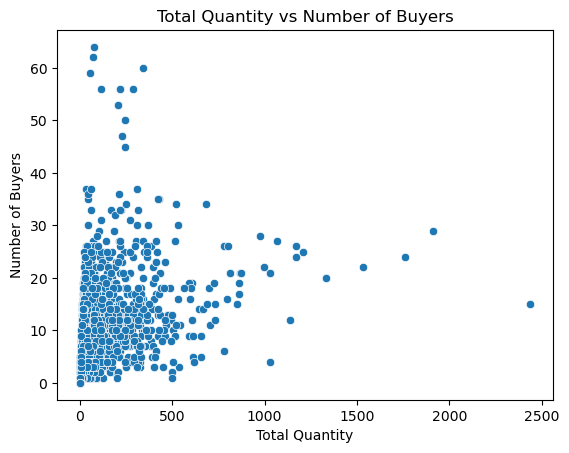

In [354]:
print(f'Correlation: {all_months_products['present_total_qty'].corr(all_months_products['present_user_cnt'])}')
sns.scatterplot(data = all_months_products, x = 'present_total_qty', y = 'present_user_cnt')
plt.title('Total Quantity vs Number of Buyers')
plt.xlabel('Total Quantity')
plt.ylabel('Number of Buyers')

At lower prices, not only is demand higher, but there is also larger variance in the quantity sold. 

Text(0.5, 1.0, 'Plot comparing product price vs log(quantity sold)')

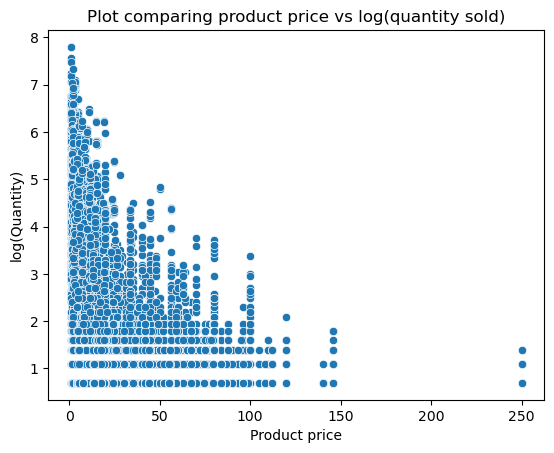

In [38]:
log_all_months_products = all_months_products.copy()
log_all_months_products['log_qty'] = np.log1p(1+all_months_products['present_total_qty'])

sns.scatterplot(data = log_all_months_products, x = 'product_price', y = 'log_qty')
plt.xlabel('Product price')
plt.ylabel('log(Quantity)')
plt.title('Plot comparing product price vs log(quantity sold)')

**Overall monthly trends**

The total number of items sold per month tends fluctuates between 15,000 and 20,000, with April seeing the highest sales above 25,000. This seems to be driven by an increase in acessories sales during the months specifically. October and November is another peak period, with a lull in sales in January - February. Overall, the categories with the highest number of sales each month are accessories and drinkware.

Apparel seems to be influenced by seasonal patterns - it peaks in the summer months of July - August during summer sales. 

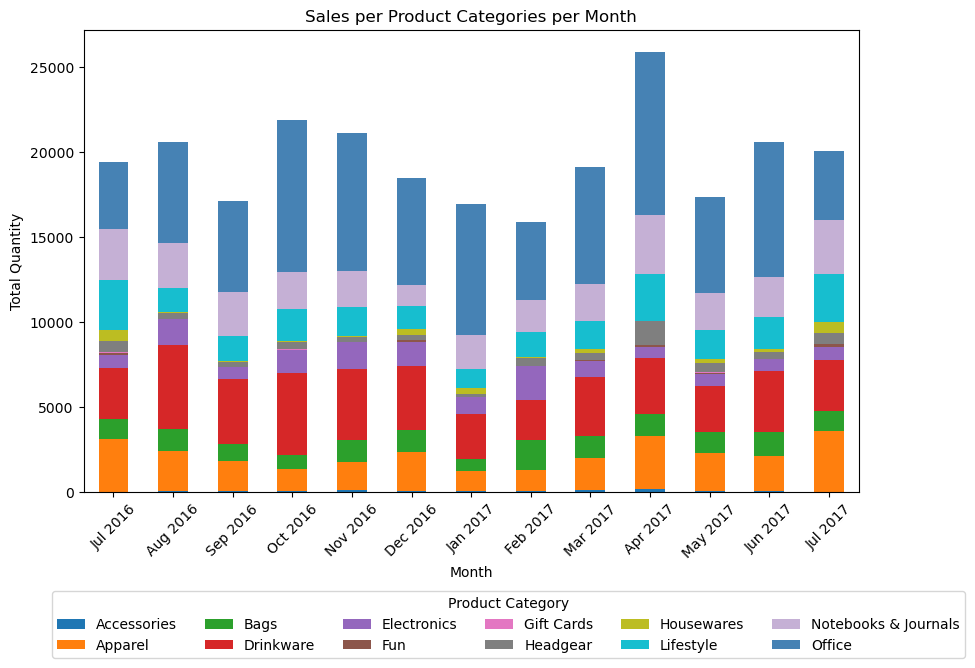

In [363]:
ax1 = all_months_products.groupby(['year_month', 'product_category'])['present_total_qty'].sum().unstack().plot(kind='bar', stacked=True, figsize=(10, 6), color = colors)
ax1.set_xticklabels(all_months_products['year_month'].dt.strftime('%b %Y').unique())
plt.ylabel('Total Quantity')
plt.xlabel('Month')
plt.title('Sales per Product Categories per Month')
plt.xticks(rotation=45)  
plt.legend(title='Product Category', bbox_to_anchor=(-0.05, -0.2), loc='upper left', ncol = 6)

Drinkware seems to be affected by seasons - sales in the fall months appear to be a lot higher.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Jul 2016'),
  Text(1, 0, 'Aug 2016'),
  Text(2, 0, 'Sep 2016'),
  Text(3, 0, 'Oct 2016'),
  Text(4, 0, 'Nov 2016'),
  Text(5, 0, 'Dec 2016'),
  Text(6, 0, 'Jan 2017'),
  Text(7, 0, 'Feb 2017'),
  Text(8, 0, 'Mar 2017'),
  Text(9, 0, 'Apr 2017'),
  Text(10, 0, 'May 2017'),
  Text(11, 0, 'Jun 2017'),
  Text(12, 0, 'Jul 2017')])

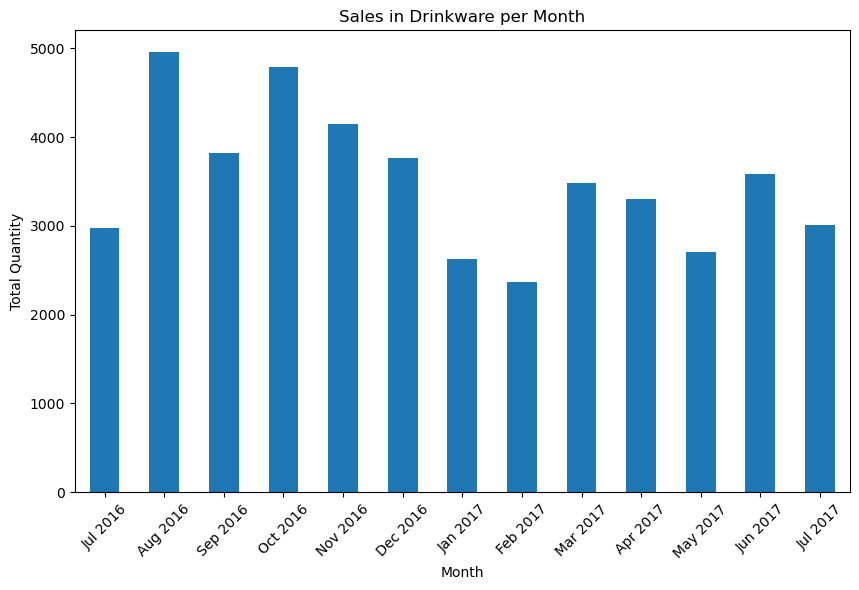

In [368]:
ax2 = all_months_products.loc[all_months_products['product_category'] == 'Drinkware'].groupby('year_month')['present_total_qty'].sum().plot(kind='bar', stacked=True, figsize=(10, 6))
ax2.set_xticklabels(all_months_products['year_month'].dt.strftime('%b %Y').unique())
plt.ylabel('Total Quantity')
plt.xlabel('Month')
plt.title('Sales in Drinkware per Month')
plt.xticks(rotation=45)  


The variation in monthly order quantities differs quite vastly across categories. Office, houseware and drinkware tend to have large variations while categories like accessories, apparel and gift cards tend to have more stable demand. This suggests that an additional feature should be added to factor for different demand variability.

Text(0.5, 1.0, 'Variation in Demand per Category')

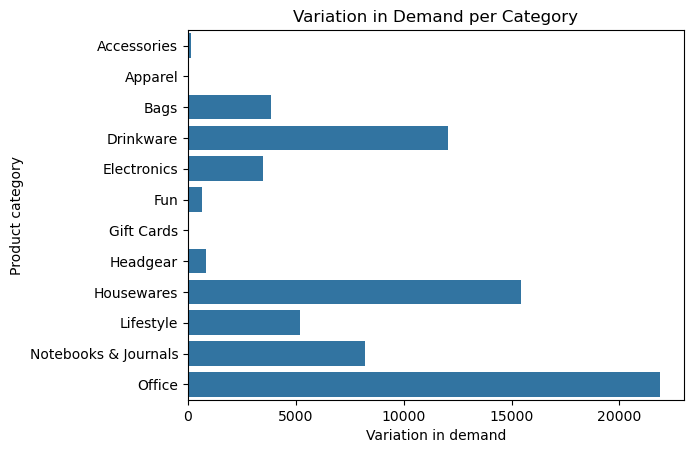

In [ ]:
sns.barplot(all_months_products.groupby('product_category')['present_total_qty'].agg('var').reset_index(name = 'variation'), 
            y = 'product_category', x = 'variation')
plt.xlabel('Variation in demand')
plt.ylabel('Product category')
plt.title('Variation in Demand per Category')

### 5. Feature engineering

<ins>Lag quantity and user count</ins>

As mentioned above, we will factor in temporal patterns by creating additional features that capture the quantity and buyer count up until 3 months prior. We will also create a factor for average quantity per user.

In [10]:
#Create columns for lag qty, lag user count, rolling window avg qty & rolling window  user count
all_months_products = all_months_products.sort_values(['product_id', 'product_price', 'year_month'])
all_months_products['prev_total_qty'] = all_months_products.groupby(['product_id','product_price'])['present_total_qty'].shift(1)
all_months_products['prev_user_cnt'] = all_months_products.groupby(['product_id','product_price'])['present_user_cnt'].shift(1)
all_months_products['prev_prev_total_qty'] = all_months_products.groupby(['product_id','product_price'])['present_total_qty'].shift(2)
all_months_products['prev_prev_user_cnt'] = all_months_products.groupby(['product_id','product_price'])['present_user_cnt'].shift(2)
all_months_products['prev_prev_prev_total_qty'] = all_months_products.groupby(['product_id','product_price'])['present_total_qty'].shift(3)
all_months_products['prev_prev_prev_user_cnt'] = all_months_products.groupby(['product_id','product_price'])['present_user_cnt'].shift(3)
all_months_products.dropna(inplace = True)
all_months_products['avg_2m_user_cnt'] = (all_months_products['prev_user_cnt'] + all_months_products['prev_prev_user_cnt'])/2
all_months_products['avg_3m_user_cnt'] = (all_months_products['prev_user_cnt'] + all_months_products['prev_prev_user_cnt'] + all_months_products['prev_prev_prev_user_cnt'])/3
all_months_products['avg_2m_total_qty'] = (all_months_products['prev_total_qty'] + all_months_products['prev_prev_total_qty'])/2
all_months_products['avg_3m_total_qty'] = (all_months_products['prev_total_qty'] + all_months_products['prev_prev_total_qty'] + all_months_products['prev_prev_prev_total_qty'])/3
all_months_products[['product_price','avg_2m_user_cnt','avg_3m_user_cnt','avg_2m_total_qty','avg_3m_total_qty']] = all_months_products[['product_price','avg_2m_user_cnt','avg_3m_user_cnt','avg_2m_total_qty','avg_3m_total_qty']].apply(lambda x: x.round(2), axis = 0)

<ins>Seasonal indicators</ins>

As observed during the EDA, some categories are influenced by seasonal patterns and major sale events. Hence, we can try to capture this by adding features for:
- Number of e-commerce sales events in a month (based on Jezy, 2024)
- Indicator for e-commerce peak season (November/December, based on Vella, 2024)
- Seasons (spring/summer/autumn/winter)

In [11]:
# Add indicators for holidays/peak periods
all_months_products["peak_period"] = all_months_products["month"].isin(["Nov", "Dec"]).astype(int)
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
holidays = [0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1]
month_holidays = pd.DataFrame({"month": month, "holidays": holidays})
all_months_products = all_months_products.merge(month_holidays, on = "month", how = "left")

In [12]:
# Add indicators for season
season = pd.DataFrame({"month": month, "season": ["Winter", "Winter", "Spring", "Spring", "Spring", "Summer", "Summer", "Summer", "Fall", "Fall", "Fall", "Winter"]})
all_months_products = pd.merge(all_months_products, season, on = "month", how = "left")

<ins>Variation in demand</ins>

To factor for the varying demand variations identified during EDA, we calculating the coefficient of variation in demand for each [product id, product price] pair and grouped them into 3 clusters (low, medium and high demand variability).
$$coefficient\,of\,variation=\frac{standard\,deviation}{mean}$$

In [13]:
# Obtain standard deviation and mean of quantity, then calculate coefficient of variation
qty_sd = all_months_products.groupby(['product_id', 'product_price'])['present_total_qty'].std().reset_index(name = 'total_qty_sd')
qty_mean = all_months_products.groupby(['product_id', 'product_price'])['present_total_qty'].mean().reset_index(name = 'total_qty_mean')
qty_stats = pd.merge(qty_sd, qty_mean, on = ['product_id', 'product_price'], how = 'left')
qty_stats['total_qty_cv'] = qty_stats['total_qty_sd']/qty_stats['total_qty_mean']

all_months_products = all_months_products.merge(qty_stats, on = ['product_id', 'product_price'], how = 'left')

In [ ]:
kmeans = KMeans(n_clusters=3, random_state = 123)
kmeans.fit(all_months_products[['total_qty_cv']])
labels = kmeans.labels_
all_months_products['xyz_cat'] = labels

In [369]:
# Rename groups so that higher group number = higher coefficient of variation
all_months_products['xyz_cat'] = all_months_products['xyz_cat'].replace({0:2, 1:3, 2:1})
all_months_products.groupby('xyz_cat')['total_qty_cv'].agg(['min', 'mean', 'max'])

,min,mean,max
xyz_cat,,,
1,0.401786,1.268066,1.816105
2,1.821458,2.370926,2.970176
3,2.972809,3.575001,3.605551


In [24]:
# with open('kmeans_model.pkl', 'wb') as f:
#     pickle.dump(kmeans, f)

### 6. Feature selection

To emulate how the model will be implemented in real life, the test set will consist of all product demands in July 2017 and the model will be trained on data from July 2016 - June 2017. All categorical variables (month, season, product category, product id) will be one-hot encoded so that they can be fed into sklearn models. This means that dimensionality reduction/feature selection is needed, as the resulting dataframe will have far too many columns and the training will be computationally expensive.

In [16]:
model_df = all_months_products.copy()
model_columns = ['month','product_id', 'product_category', 'product_price', 'holidays', 'season', 'xyz_cat','peak_period','prev_user_cnt', 'prev_total_qty', 'prev_prev_user_cnt', 'prev_prev_total_qty', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty', 'avg_2m_user_cnt', 'avg_3m_user_cnt', 'avg_2m_total_qty', 'avg_3m_total_qty']

test_df = model_df.loc[model_df["year_month"] == '2017-07-01']
train_df = model_df.loc[model_df["year_month"] != '2017-07-01']

all_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

X_train = train_df[model_columns]
X_train['month'] = pd.Categorical(X_train['month'], categories = all_months)
X_train['season'] = pd.Categorical(X_train['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_train = pd.get_dummies(X_train, columns = ['product_category', 'product_id', 'month','season'], drop_first = True)
y_train = train_df['present_total_qty']

X_test = test_df[model_columns]
X_test['month'] = pd.Categorical(X_test['month'], categories = all_months)
X_test['season'] = pd.Categorical(X_test['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_test = pd.get_dummies(X_test, columns = ['product_category', 'product_id', 'month', 'season'], drop_first = True)
y_test = test_df['present_total_qty']

We will use RFECV to select the most important features to maintain. RMSE was chosen as the evaluation metric for RFECV as it will ultimately be used as the evaluation metric for the model. This is because we want to penalise large errors more, since unexpected high demand can lead to the selling out of products and result in a significant loss of sales.

In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, np.round(y_pred)))

rmse_scorer = make_scorer(rmse, greater_is_better=False)


In [ ]:
rf_rfecv = RandomForestRegressor(random_state = 999, n_jobs = -1, n_estimators = 100, max_features = 5)
selector = RFECV(estimator = rf_rfecv, step = 0.15, cv = 5, n_jobs = -1, scoring = rmse_scorer, verbose = 2)
selector.fit(X_train, y_train)
selected_columns = X_train.columns[selector.support_]

selected_features_list = selected_columns.tolist()

# with open('selected_features.pkl', 'wb') as f:
#     pickle.dump(selected_features_list, f)

In [364]:
X_train_rfecv = X_train[selected_columns]
X_test_rfecv = X_test[selected_columns]


### 7. Model training

We will be testing 3 models: random forest, XGBoost and XGBoost distribution. Random forest and XGboost were chosen based on a study by Douaioui et al. (2024), while XGBoost distribution was added to explore the possibility of constructing a demand distribution curve. This was so as to provide suppliers with more flexibility in inventory management should they wish to prioritize certain products and adapt a more conservative approach in their demand forecasting.

#### Random forest

In [ ]:
rf = RandomForestRegressor(random_state = 121)
param_grid = {
    'max_depth': [3, 5],
    'max_features': [3, 5],
    'min_samples_split': [30, 40],
    'n_estimators': [100, 150],
    'min_samples_leaf': [10, 15]
}
rf_rmse_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,
                          scoring=rmse_scorer)
rf_rmse_grid_search.fit(X_train_rfecv, y_train)

In [366]:
print(f'Chosen hyperparameters: {rf_rmse_grid_search.best_params_}')
rf_rmse_best_model = rf_rmse_grid_search.best_estimator_
print(f'CV RMSE: {round(-rf_rmse_grid_search.best_score_, 2)}')

# rf_rmse_best_model = RandomForestRegressor(max_depth=5, max_features=5, min_samples_split=40, min_samples_leaf = 100, 
#                                            n_estimators=100, random_state=121)
# rf_rmse_best_model.fit(X_train_rfecv, y_train)

importance_rf_rmse_df= pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': rf_rmse_best_model.feature_importances_
})

importance_rf_rmse_df.sort_values(by='Importance', ascending=False)[:10]


Chosen hyperparameters: {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 100}
CV RMSE: 27.07


,Feature,Importance
5,prev_total_qty,0.104562
9,prev_prev_prev_total_qty,0.089120
12,avg_2m_total_qty,0.072020
13,avg_3m_total_qty,0.062853
6,prev_prev_user_cnt,0.056150
11,avg_3m_user_cnt,0.054263
7,prev_prev_total_qty,0.048106
223,product_id_GGOEGOAC021799,0.041109
8,prev_prev_prev_user_cnt,0.039954
10,avg_2m_user_cnt,0.036906


Train MAE: 7.444902707275804


Text(0.5, 1.0, 'Error plot on train data')

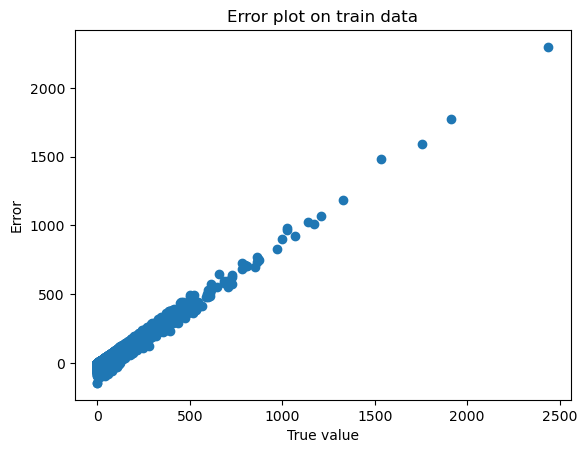

In [370]:
rf_rmse_best_model.fit(X_train_rfecv, y_train)
y_train_pred = rf_rmse_best_model.predict(X_train_rfecv)
error = y_train - np.round(y_train_pred)

print(f'Train MAE: {np.mean(abs(error))}')
plt.scatter(y_train, error)
plt.xlabel('True value')
plt.ylabel('Error')
plt.title('Error plot on train data')

### XGBoost

In [ ]:
xgboost = xgb.XGBRegressor(random_state=122, learning_rate = 0.008, reg_lambda = 30)

param_grid = {
    'max_depth': [12, 15],
    'colsample_bytree': [0.95, 1],
    'subsample': [0.95, 1],
    'n_estimators': [125, 175],
    'gamma': [8, 10]
}
xgb_grid_search = GridSearchCV(estimator = xgboost, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring = rmse_scorer)
xgb_grid_search.fit(X_train_rfecv, y_train)

In [111]:
# xgb_best_model = xgb.XGBRegressor(random_state=122, colsample_by_tree = 0.95, gamma = 8, reg_lambda = 30,
#                                   learning_rate = 0.008, max_depth = 12, n_estimators = 175, subsample = 0.95)
# xgb_best_model.fit(X_train_rfecv, y_train)


print(f'Chosen hyperparameters: {xgb_grid_search.best_params_}')
xgb_best_model = xgb_grid_search.best_estimator_

print(f'CV Score: {round(-xgb_grid_search.best_score_, 2)}')

importance_xgb_df = pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': xgb_best_model.feature_importances_
})

importance_xgb_df.sort_values(by='Importance', ascending=False)[:10]


Chosen hyperparameters: {'colsample_bytree': 0.95, 'gamma': 8, 'max_depth': 12, 'n_estimators': 175, 'subsample': 0.95}
CV Score: 26.01


,Feature,Importance
197,product_id_GGOEGGOA017399,0.310524
13,avg_3m_total_qty,0.200512
12,avg_2m_total_qty,0.032626
195,product_id_GGOEGFYQ016599,0.019337
166,product_id_GGOEGDHR018499,0.014175
227,product_id_GGOEGOAQ018099,0.012672
201,product_id_GGOEGHGT019599,0.011348
190,product_id_GGOEGFKQ020399,0.010643
217,product_id_GGOEGOAB015899,0.010483
200,product_id_GGOEGHGR019499,0.009823


Train MAE: 5.3588197969543145


Text(0.5, 1.0, 'Error plot on train data')

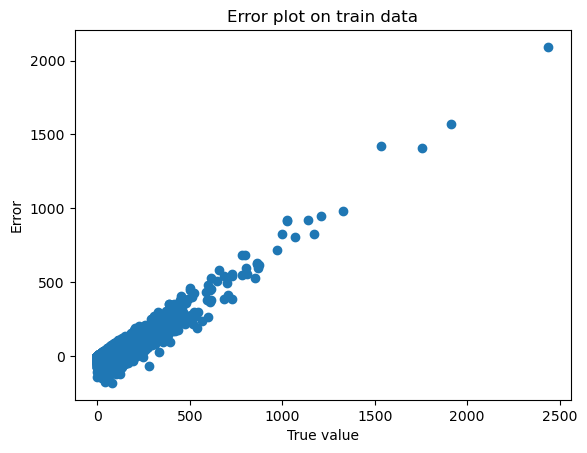

In [112]:
xgb_best_model.fit(X_train_rfecv, y_train)
y_train_pred = xgb_best_model.predict(X_train_rfecv)
error = y_train - np.round(y_train_pred)

print(f'Train MAE: {np.mean(abs(error))}')
plt.scatter(y_train, error)
plt.xlabel('True value')
plt.ylabel('Error')
plt.title('Error plot on train data')

#### XGBoost Distribution

In [24]:
def rmse_xgbd(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, np.round(y_pred[0])))

rmse_scorer_xgbd = make_scorer(rmse_xgbd, greater_is_better=False)

In [ ]:
param_grid = {
    'max_depth': [12, 15],
    'subsample': [0.8, None],
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.018, 0.02],
    'reg_lambda': [3, 5]
}

xgbd = XGBDistribution(distribution = 'poisson', random_state = 123, gamma = 1)

xgbd_grid_search = GridSearchCV(estimator = xgbd, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring = rmse_scorer_xgbd)
xgbd_grid_search.fit(X_train_rfecv, y_train)


In [48]:
# xgbd_best_model = XGBDistribution(distribution = 'poisson', random_state = 123, 
#                                   gamma = 1, reg_lambda = 3,
#                                   learning_rate = 0.018, max_depth = 15, n_estimators = 250, subsample = None)
# xgbd_best_model.fit(X_train_rfecv, y_train)

print(f'Chosen hyperparameters: {xgbd_grid_search.best_params_}')
xgbd_best_model = xgbd_grid_search.best_estimator_

print(f'CV Score: {-round(xgbd_grid_search.best_score_,2)}')

importance_xgbd_df = pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': xgbd_best_model.feature_importances_
})

importance_xgbd_df.sort_values(by='Importance', ascending=False)[:10]


Chosen hyperparameters: {'learning_rate': 0.018, 'max_depth': 15, 'n_estimators': 250, 'reg_lambda': 3, 'subsample': None}
CV Score: 25.87


,Feature,Importance
197,product_id_GGOEGGOA017399,0.669928
156,product_id_GGOEGDHC018299,0.108642
2,xyz_cat,0.019629
13,avg_3m_total_qty,0.016811
205,product_id_GGOEGHPB071610,0.015654
194,product_id_GGOEGFSR022099,0.007521
232,product_id_GGOEGOAR021999,0.006431
223,product_id_GGOEGOAC021799,0.005936
220,product_id_GGOEGOAB021699,0.005128
228,product_id_GGOEGOAQ020099,0.004528


Train MAE: 2.4564033417935702


Text(0.5, 1.0, 'Error plot on train data')

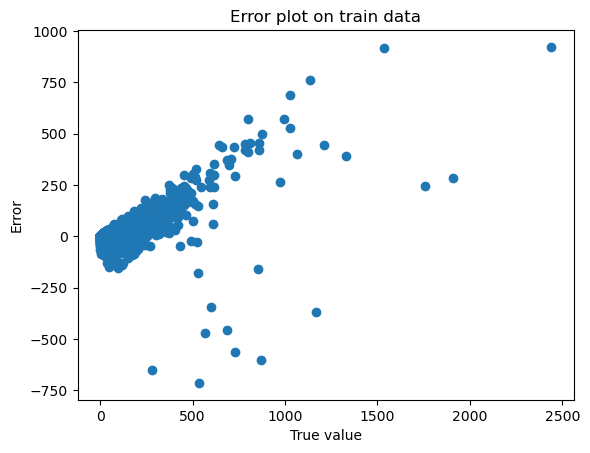

In [43]:
xgbd_best_model = XGBDistribution(distribution = 'poisson', random_state = 123, 
                                  gamma = 1, reg_lambda = 3,
                                  learning_rate = 0.018, max_depth = 15, n_estimators = 250, subsample = None)
xgbd_best_model.fit(X_train_rfecv, y_train)
y_train_pred = xgbd_best_model.predict(X_train_rfecv)
error = y_train - np.round(y_train_pred[0])

print(f'Train MAE: {np.mean(abs(error))}')
plt.scatter(y_train, error)
plt.xlabel('True value')
plt.ylabel('Error')
plt.title('Error plot on train data')

### 7.1 Model Building (with log transformation)

So far we have seen that the MAE is a lot lower than the RMSE and the distribution of validation error is extremely right skewed. The plot of error against true values has also shown that large errors tend to be for products with high demand, and the EDA earlier revealed heteroscedasticity in the total quantity sold. This suggests that perhaps applying log transformation on the demand may help improve the model performance.

In [47]:
# Log transform all quantity columns (add 1 to avoid zero division)
all_months_products['present_total_qty_log'] = np.log1p(all_months_products['present_total_qty'] + 1)
all_months_products['prev_total_qty_log'] = np.log1p(all_months_products['prev_total_qty'] + 1)
all_months_products['prev_prev_total_qty_log'] = np.log1p(all_months_products['prev_prev_total_qty'] + 1)
all_months_products['prev_prev_prev_total_qty_log'] = np.log1p(all_months_products['prev_prev_prev_total_qty'] + 1)
all_months_products['avg_2m_total_qty_log'] = np.log1p(all_months_products['avg_2m_total_qty'] + 1)
all_months_products['avg_3m_total_qty_log'] = np.log1p(all_months_products['avg_3m_total_qty'] + 1)


In [48]:
model_log_df = all_months_products.copy()
model_log_columns = ['month','product_id', 'product_category', 'product_price', 'holidays', 'season', 'xyz_cat','peak_period','prev_user_cnt', 'prev_total_qty_log', 'prev_prev_user_cnt', 'prev_prev_total_qty_log', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty_log', 'avg_2m_user_cnt', 'avg_3m_user_cnt', 'avg_2m_total_qty_log', 'avg_3m_total_qty_log']

test_log_df = model_log_df.loc[model_log_df["year_month"] == '2017-07-01']
train_log_df = model_log_df.loc[model_log_df["year_month"] != '2017-07-01']

all_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

X_train_log = train_log_df[model_log_columns]
X_train_log['month'] = pd.Categorical(X_train_log['month'], categories = all_months)
X_train_log['season'] = pd.Categorical(X_train_log['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_train_log = pd.get_dummies(X_train_log, columns = ['product_category', 'product_id', 'month','season'], drop_first = True)
y_train_log = train_log_df['present_total_qty_log']

X_test_log = test_log_df[model_log_columns]
X_test_log['month'] = pd.Categorical(X_test_log['month'], categories = all_months)
X_test_log['season'] = pd.Categorical(X_test_log['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_test_log = pd.get_dummies(X_test_log, columns = ['product_category', 'product_id', 'month', 'season'], drop_first = True)
y_test_log = test_log_df['present_total_qty_log']

In [49]:
def log_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.round(np.exp(y_true)), np.round(np.exp(y_pred))))

log_rmse_scorer = make_scorer(log_rmse, greater_is_better=False)

#### Random forest

In [ ]:
log_rfecv = RandomForestRegressor(random_state = 999, n_jobs = -1, n_estimators = 100, max_features = 5)
selector_log = RFECV(estimator = log_rfecv, step = 0.15, cv = 5, n_jobs = -1, scoring = log_rmse_scorer, verbose = 2)
selector_log.fit(X_train_log, y_train_log)
selected_columns_log = X_train_log.columns[selector_log.support_]

X_train_log_rfecv = X_train_log[selected_columns_log]
X_test_log_rfecv = X_test_log[selected_columns_log]

In [371]:
len(selected_columns_log)

118

In [ ]:
rf_log = RandomForestRegressor(random_state = 124)
param_grid = {
    'max_depth': [5, 10],
    'max_features': [5, 10],
    'min_samples_split': [25, 35],
    'n_estimators': [50, 100],
    'min_samples_leaf': [30, 35]
}
rf_log_grid_search = GridSearchCV(estimator = rf_log, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,
                          scoring=log_rmse_scorer)
rf_log_grid_search.fit(X_train_log_rfecv, y_train_log)

In [58]:
print(rf_log_grid_search.best_params_)
rf_log_best_model = rf_log_grid_search.best_estimator_

# rf_log_best_model = RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf = 30, min_samples_split=25, 
#                                               n_estimators=100, random_state=124)
# rf_log_best_model.fit(X_train_log_rfecv, y_train_log)

print(f'CV Score: {-round(rf_log_grid_search.best_score_, 2)}')

importance_rf_log_df= pd.DataFrame({
    'Feature': X_train_log_rfecv.columns,
    'Importance': rf_log_best_model.feature_importances_
})

importance_rf_log_df.sort_values(by='Importance', ascending=False)[:10]

{'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 30, 'min_samples_split': 25, 'n_estimators': 100}
CV Score: 27.05


,Feature,Importance
13,avg_3m_total_qty_log,0.126322
12,avg_2m_total_qty_log,0.109913
5,prev_total_qty_log,0.105353
10,avg_2m_user_cnt,0.100035
11,avg_3m_user_cnt,0.089408
7,prev_prev_total_qty_log,0.067656
0,product_price,0.067217
8,prev_prev_prev_user_cnt,0.065405
4,prev_user_cnt,0.065313
9,prev_prev_prev_total_qty_log,0.059335


Train MAE: 0.39925112790880984


Text(0.5, 1.0, 'Error plot on train data')

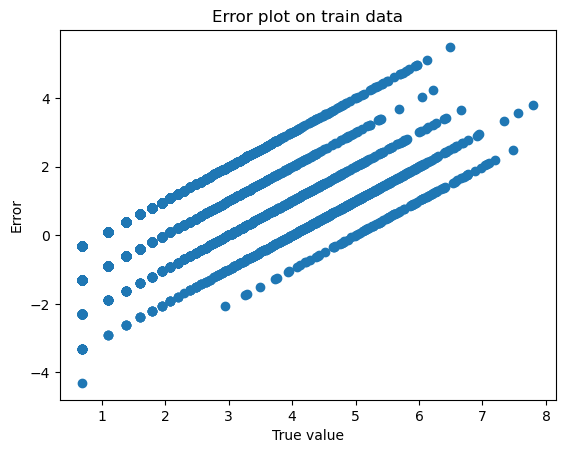

In [372]:
rf_log_best_model.fit(X_train_log_rfecv, y_train_log)
y_train_log_pred = rf_log_best_model.predict(X_train_log_rfecv)
error = y_train_log - np.round(y_train_log_pred)

print(f'Train MAE: {np.mean(abs(error))}')
plt.scatter(y_train_log, error)
plt.xlabel('True value')
plt.ylabel('Error')
plt.title('Error plot on train data')

### 8. Final Model

We will choose the XGBoost distribution model as it had the lowest CV error of 25.78. Its underpredictions were also less severe, with the largest error being less than 1000 (other models had errors above 1500). 

Upon testing on the test set, the model had an RMSE Of 22.26.

In [73]:
y_test_pred = xgbd_best_model.predict(X_test_rfecv)
print(f'Test RMSE: {round(mean_squared_error(y_test, np.round(y_test_pred[0]), squared = False), 2)}')
print(f'Test MAE: {round(np.mean(abs(y_test - np.round(y_test_pred[0]))), 2)}')

Test RMSE: 22.26
Test MAE: 3.85


It appears that the most important features mostly circle around the product IDs, though the COV clustering and historical data are also important.

In [115]:
importance_xgbd_df.sort_values(by='Importance', ascending=False)[:10]


,Feature,Importance
197,product_id_GGOEGGOA017399,0.669928
156,product_id_GGOEGDHC018299,0.108642
2,xyz_cat,0.019629
13,avg_3m_total_qty,0.016811
205,product_id_GGOEGHPB071610,0.015654
194,product_id_GGOEGFSR022099,0.007521
232,product_id_GGOEGOAR021999,0.006431
223,product_id_GGOEGOAC021799,0.005936
220,product_id_GGOEGOAB021699,0.005128
228,product_id_GGOEGOAQ020099,0.004528


The relatively high RMSE seems to be due to the presence of a small number of very large volume sales, which are penalised more.

Text(0.5, 0, 'Predicted Error')

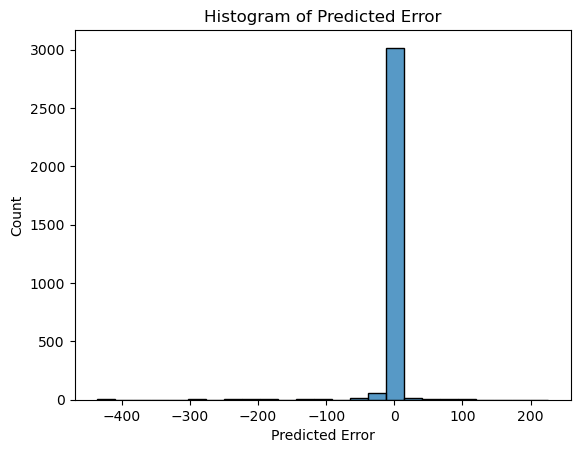

In [376]:
error_qty_df = pd.DataFrame({'y_test': y_test, 'error': np.round(y_test_pred[0] - y_test)})
sns.histplot(data = error_qty_df, x = 'error', bins = 25)
plt.title('Histogram of Predicted Error')
plt.xlabel('Predicted Error')

In [377]:
# Save the chosen model
# with open('demand_forecasting_xgbd_model.pkl', 'wb') as f:
#     pickle.dump(xgbd_best_model, f)

### 9. Downloading data used/produced in this notebook

Train predictions

In [75]:
model_columns = ['month','product_id', 'product_category', 'product_price', 'holidays', 'season', 'xyz_cat','peak_period','prev_user_cnt', 'prev_total_qty', 'prev_prev_user_cnt', 'prev_prev_total_qty', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty', 'avg_2m_user_cnt', 'avg_3m_user_cnt', 'avg_2m_total_qty', 'avg_3m_total_qty']
forecast_df = all_months_products.loc[(all_months_products['year_month'] >= '2016-08-01') & (all_months_products['year_month'] <= '2017-07-01'), model_columns]

all_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

forecast_df['month'] = pd.Categorical(forecast_df['month'], categories = all_months)
forecast_df['season'] = pd.Categorical(forecast_df['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
forecast_df = pd.get_dummies(forecast_df, columns = ['product_category', 'product_id', 'month','season'], drop_first = True)

forecast_df_rfecv = forecast_df[selected_columns]
forecast_pred = np.round(xgbd_best_model.predict(forecast_df_rfecv)[0])

In [ ]:
aug_16_jul_17_forecast = all_months_products.loc[(all_months_products['year_month'] >= '2016-08-01') & (all_months_products['year_month'] <= '2017-07-01'), ['year_month', 'product_id', 'product_price', 'product_category']]
aug_16_jul_17_forecast = pd.merge(aug_16_jul_17_forecast, id_name_map, how = "left", on = "product_id")
aug_16_jul_17_forecast['forecast_qty'] = forecast_pred
aug_16_jul_17_forecast.to_csv("../data/train_predictions.csv", index = False)

Forecast into future (Aug 2017)

In [79]:
base_df = all_months_products.loc[all_months_products['year_month'] == '2017-07-01'].sort_index()
map_xyz = all_months_products[['product_id', 'product_price', 'xyz_cat']].drop_duplicates()

pred_future = all_months_products.loc[all_months_products['year_month'] == '2017-07-01', ['product_id', 'product_price', 'product_category']].sort_index()
pred_future['month'] = 'Aug'
pred_future['holidays'] = holidays[7]
pred_future['season'] = 'Summer'
pred_future['xyz_cat'] = pred_future.apply(lambda x: map_xyz.loc[(map_xyz['product_id'] == x['product_id']) & 
                                                                 (map_xyz['product_price'] == x['product_price']),'xyz_cat'].values[0], axis = 1)
pred_future['peak_period'] = 0
pred_future['prev_user_cnt'] = base_df['present_user_cnt']
pred_future['prev_total_qty'] = base_df['present_total_qty']
pred_future['prev_prev_user_cnt'] = base_df['prev_user_cnt']
pred_future['prev_prev_total_qty'] = base_df['prev_total_qty']
pred_future['prev_prev_prev_user_cnt'] = base_df['prev_prev_user_cnt']
pred_future['prev_prev_prev_total_qty'] = base_df['prev_prev_total_qty']
pred_future['avg_2m_user_cnt'] = (pred_future['prev_user_cnt'] + pred_future['prev_prev_user_cnt'])/2
pred_future['avg_3m_user_cnt'] = (pred_future['prev_user_cnt'] + pred_future['prev_prev_user_cnt'] + pred_future['prev_prev_prev_user_cnt'])/3
pred_future['avg_2m_total_qty'] = (pred_future['prev_total_qty'] + pred_future['prev_prev_total_qty'])/2
pred_future['avg_3m_total_qty'] = (pred_future['prev_total_qty'] + pred_future['prev_prev_total_qty'] + pred_future['prev_prev_prev_total_qty'])/3
pred_future = pred_future[model_columns]
pred_future['month'] = pd.Categorical(pred_future['month'], categories = all_months)
pred_future['season'] = pd.Categorical(pred_future['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
pred_future.head()
pred_future = pd.get_dummies(pred_future, columns = ['product_category', 'product_id', 'month','season'], drop_first = True)
pred_df_rfecv = pred_future[selected_columns]

In [74]:
pred_future_values = np.round(xgbd_best_model.predict(pred_df_rfecv)[0])
forecast_df = base_df[['product_id', 'product_price', 'product_category']].drop_duplicates()
forecast_df['year_month'] = pd.to_datetime('2017-08-01')
forecast_df = pd.merge(forecast_df, id_name_map, how = 'left', on = 'product_id')
forecast_df = forecast_df[['year_month', 'product_id', 'product_price', 'product_category', 'product_name']]
forecast_df['forecast_qty'] = pred_future_values

In [82]:
forecast_df.to_csv("../data/forecast_predictions.csv", index = False)

Train data

In [350]:
historical_data = model_df[["year_month", "product_id", "product_price", "product_category", "present_total_qty"]]
historical_data = pd.merge(historical_data, id_name_map, how = 'left', on = 'product_id')
historical_data.to_csv("../data/train_true.csv", index = False)
 
#  historical_data = train_df[["year_month", "product_id", "product_price", "product_category", "present_total_qty"]]
# historical_data = pd.merge(historical_data, id_name_map, how = 'left', on = 'product_id')
# historical_data.to_csv("../data/train_true.csv", index = False)

### 10. Works cited


Douaioui, M., Oucheikh, R., Benmoussa, O., & Mabrouki, C. (2024) "Machine Learning and Deep Learning Models for Demand Forecasting in Supply Chain Management: A Critical Review." *Appl. Syst. Innov. 2024, 7*(5), 93. https://www.mdpi.com/2571-5577/7/5/93

Jezy, M. (2024). Amazon Peak Season 2024: All about the most important peak season days in e-commerce. *Quivo*. https://quivo.co/us/amazon-peak-season-most-important-e-commerce-days-2024

Seidel, D. (2024). An explanation of ABC XYZ inventory analysis and why it adds value. *EazyStock*. https://www.eazystock.com/uk/blog-uk/abc-xyz-analysis-for-inventory-and-how-can-it-add-value/ 

Vella, V. C. (2024) Prepare for peak season: Logistic tips for small businesses. *DHL*. https://www.dhl.com/discover/en-global/small-business-advice/business-innovation-trends/peak-season/peak-holiday-season-e-commerce-toolkit